In [20]:
from Environment.snake_game import SnakeGame
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import imageio # For video generation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import random

GAME_WIDTH = 20
GAME_HEIGHT = 20
FOOD_AMOUNT = 1
GRASS_GROWTH = 0.001
MAX_GRASS = 0.05
BORDER_SIZE = 1 # Add a visual border of 1 pixel
MAX_GAME_STEPS = 500 # Set a limit for the game length
VIDEO_FILENAME = "snake_ai_player.gif"
FPS = 5 # Faster for smoother video

BATCH_SIZE = 64
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.005
EPSILON_DECAY = 0.995
REPLAY_BUFFER_SIZE = 1000
LEARNING_RATE = 1e-4
TARGET_UPDATE_FREQ = 100
EVAL_INTERVAL = 500
TEMPERATURE_END = 0.1
TEMPERATURE_START = 2.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
"""
    Heuristic Player
"""
class SnakeHeuristic:
    def __init__(self, game: SnakeGame):
        self.game = game
        # Map: game_direction_idx -> (row_change, col_change)
        self.delta_coords = {
            0: (-1, 0),  # Up
            1: (0, 1),   # Right
            2: (1, 0),   # Down
            3: (0, -1)   # Left
        }

    def _get_closest_apple_pos(self):
        if not self.game.apples:
            return None
        
        head_r, head_c = self.game.snake[0]
        closest_apple = None
        min_dist = float('inf')

        for apple_r, apple_c in self.game.apples:
            dist = abs(apple_r - head_r) + abs(apple_c - head_c)
            if dist < min_dist:
                min_dist = dist
                closest_apple = (apple_r, apple_c)
        return closest_apple

    def _is_safe_move(self, next_head_r, next_head_c):
        if not (0 <= next_head_r < self.game.height and \
                0 <= next_head_c < self.game.width):
            return False

        if (next_head_r, next_head_c) in self.game.snake[1:]:
            return False
            
        return True

    def choose_action(self):
        target_apple_pos = self._get_closest_apple_pos()

        if target_apple_pos is None:
            return 0

        head_r, head_c = self.game.snake[0]
        current_game_direction = self.game.direction

        candidate_actions = []

        for action_value in [-1, 0, 1]:
            next_game_direction = (current_game_direction + action_value) % 4
            if next_game_direction < 0: next_game_direction += 4

            dr, dc = self.delta_coords[next_game_direction]

            next_head_r, next_head_c = head_r + dr, head_c + dc

            if self._is_safe_move(next_head_r, next_head_c):
                dist_to_apple = abs(target_apple_pos[0] - next_head_r) + \
                                abs(target_apple_pos[1] - next_head_c)
                candidate_actions.append({
                    'action': action_value, 
                    'distance': dist_to_apple
                })
        
        if not candidate_actions:
            return 0

        def sort_key(candidate):
            action = candidate['action']
            preference = 0
            if action == 1: preference = 1
            elif action == -1: preference = 2
            return (candidate['distance'], preference)

        candidate_actions.sort(key=sort_key)
        
        return candidate_actions[0]['action']

    def play_game_and_record(self, max_steps: int, video_filename: str = "snake_heuristic_game.gif", fps: int = 5):
        frames = []
        history = {
            'board': [],
            'reward': [],
            'done': -1,
            'info': []
        }
        board_state, reward, done, info = self.game.reset()
        
        frames.append((board_state * 255).astype(np.uint8))

        print(f"Starting game with heuristic. Max steps: {max_steps}. Recording to {video_filename}")

        for step_num in range(max_steps):
            history['board'].append(board_state)
            history['reward'].append(reward)
            history['info'].append(info)
            if done:
                history['done'] = step_num
                print(f"Game ended prematurely at step {step_num} before taking action. Score: {info['score']}")
                break

            action_to_take = self.choose_action()
            board_state, reward, done, info = self.game.step(action_to_take)
            
            frames.append((board_state * 255).astype(np.uint8))
            
            if (step_num + 1) % 100 == 0:
                 print(f"Step {step_num+1}/{max_steps}, Score: {info['score']}, Done: {done}")


            """if done:
                print(f"Game over at step {step_num+1}. Final Score: {info['score']}")
                break"""
        else:
            print(f"Game finished after {max_steps} steps (max_steps reached). Final Score: {self.game.score}")

        if frames:
            print(f"Saving video with {len(frames)} frames at {fps} FPS...")
            try:
                imageio.mimsave(video_filename, frames, fps=fps)
                print(f"Video saved successfully as {video_filename}")
            except Exception as e:
                print(f"Error saving video: {e}")
                print("Please ensure you have an imageio backend installed (e.g., 'pip install imageio[ffmpeg]' for MP4 or 'pip install imageio pillow' for GIF).")
        else:
            print("No frames recorded.")

        return history
    
"""
    Simple heuristic for training
    Does not avoid collisions with walls and itself
    Did not seem to be a problem
    If it happens, its a learning experience
"""
def get_ideal_direction(food_coords, head_coords, direction):
    dx = food_coords[0] - head_coords[0]  # positive = food is to the right
    dy = food_coords[1] - head_coords[1]  # positive = food is above
    W, N, E, S = 0, 1, 2, 3    # this may look wrong but I have to do this so this works, I didnt bother finding out why sorry :P
    LEFT, SAME_DIR, RIGHT = -1, 0, 1
    GO = 0 # default is going in the same direction

    if dx == 0:         # food on same x axis
        if dy > 0:      # food above
            if direction == N:   # going up
                GO = SAME_DIR        # keep going up
            elif direction == E:   # going right
                GO = LEFT
            else:
                GO = RIGHT  # if going left or up
        else:
            if direction == S:   # going up
                GO = SAME_DIR        # keep going up
            elif direction == E:   # going right
                GO = RIGHT
            else:
                GO = LEFT      # if going left or up

    elif dx > 0:
        if direction == N or direction == W: # if going up or in the opposite direction turn right
            GO = RIGHT
        elif direction == S:
            GO = LEFT
        elif direction == E:
            GO = SAME_DIR
    else:
        if direction == S or direction == E: # if going down or in the opposite direction turn right
            GO = RIGHT
        elif direction == N:
            GO = LEFT
        elif direction == W:
            GO = SAME_DIR

    return GO

def heuristic_move(game):
    total_score, food_coords, head_coords, tails_coords, direction = game.get_state()
    next_move = get_ideal_direction(food_coords[0], head_coords, direction)
    return next_move

In [22]:
def evaluate_dqn_policy(game: SnakeGame, policy_net: nn.Module, max_steps: int, video_filename=None, fps=5):
    frames = []
    state, _, done, info = game.reset()
    state = np.transpose(state, (2, 0, 1))  # CHW for PyTorch

    if video_filename:
        frames.append((np.transpose(state, (1, 2, 0)) * 255).astype(np.uint8))

    total_reward = 0
    for step in range(max_steps):
        if done:
            break

        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = policy_net(state_tensor)
            action_idx = q_values.argmax().item()
            action = [-1, 0, 1][action_idx]

        next_state, reward, done, info = game.step(action)
        next_state = np.transpose(next_state, (2, 0, 1))
        state = next_state
        total_reward += reward

        if video_filename:
            frame = (np.transpose(state, (1, 2, 0)) * 255).astype(np.uint8)
            frames.append(frame)

    if video_filename and frames:
        imageio.mimsave(video_filename, frames, fps=fps)

    return info['score'], total_reward


"""
    DQN, Replay Buffer, and Helper Functions
"""
class SnakeDQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(SnakeDQN, self).__init__()
        C, H, W = input_shape
        
        self.conv = nn.Sequential(
            nn.Conv2d(C, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        dummy_input = torch.zeros(1, *input_shape)
        conv_out_size = self.conv(dummy_input).view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
    
def compute_q_loss(pred_q, action, reward, next_state, done, model, gamma=0.99):
    with torch.no_grad():
        next_q = model(next_state)
        max_next_q = next_q.max(1)[0]
        target_q = reward + gamma * max_next_q * (1 - done)

    pred_q_action = pred_q.gather(1, action.unsqueeze(1)).squeeze(1)
    loss = F.mse_loss(pred_q_action, target_q)
    return loss

def compute_loss(predicted_q_values, actions, target_q_values):
    action_indices = actions + 1
    selected_q = predicted_q_values.gather(1, action_indices.unsqueeze(1)).squeeze(1)
    loss = F.mse_loss(selected_q, target_q_values)
    return loss, selected_q

def boltzmann_action(q_values, temperature):
    probabilities = F.softmax(q_values / temperature, dim=1)
    return torch.multinomial(probabilities, 1).item()

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, min(batch_size, len(self.buffer)))
        states, actions, rewards, next_states, dones = zip(*samples)
        
        return (
            torch.tensor(np.array(states), dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(np.array(next_states), dtype=torch.float32),
            torch.tensor(dones, dtype=torch.bool)
        )

    def __len__(self):
        return len(self.buffer)
    
class PrioritizedReplayBuffer:
    def __init__(self, capacity=10000, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = []
        self.pos = 0

    def push(self, state, action, reward, next_state, done, td_error=1.0):
        max_priority = max(self.priorities, default=1.0)

        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
            self.priorities.append(max_priority)
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
            self.priorities[self.pos] = max_priority
            self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.buffer) == 0:
            return [], [], [], [], [], []

        scaled_priorities = np.array(self.priorities) ** self.alpha
        probs = scaled_priorities / scaled_priorities.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        states, actions, rewards, next_states, dones = zip(*samples)
        return (
            torch.tensor(np.array(states), dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(np.array(next_states), dtype=torch.float32),
            torch.tensor(dones, dtype=torch.bool),
            indices
        )
    
    def __len__(self):
        return len(self.buffer)


    def update_priorities(self, indices, td_errors):
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = abs(td_error.item()) + 1e-5


In [57]:
def plot_training_metrics(scores, losses, q_values):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(scores)
    plt.title("Scores")
    plt.xlabel("Episode")
    plt.ylabel("Score")

    plt.subplot(1, 3, 2)
    plt.plot(losses)
    plt.title("Average Loss per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Loss")

    plt.subplot(1, 3, 3)
    plt.plot(q_values)
    plt.title("Average Q-value per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Q-value")

    plt.tight_layout()
    plt.show()


def evaluate_efficiency(scores, q_values, total_time):
    avg_score = np.mean(scores)
    avg_q = np.mean(q_values)
    print(f"--- Evaluation Summary ---")
    print(f"Average Score: {avg_score:.2f}")
    print(f"Average Q-value: {avg_q:.4f}")
    print(f"Training Time: {total_time:.2f} seconds")
    print(f"Score / Time: {avg_score / total_time:.4f}")
    print(f"Q-value / Time: {avg_q / total_time:.4f}")


"""
    Task 1 - train simple
"""
def train_dqn_simple(env, model, using_heuristic=False, heuristic=None):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    epsilon = EPSILON_START

    scores = []
    losses = []
    q_values = []

    max_train_episodes = 1000
    max_total_steps = max_train_episodes*MAX_GAME_STEPS

    for episode in range(1, max_train_episodes + 1):
        state, _, done, _ = env.reset()
        state = np.transpose(state, (2, 0, 1))
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

        total_loss = 0
        total_q = 0
        steps = 0
        done = False
        
        while not done and steps < MAX_GAME_STEPS:
            # Epsilon-greedy action
            if random.random() < epsilon:
                if using_heuristic:
                    action = heuristic.choose_action()
                    #action = heuristic_move(env)
                else:
                    action = random.choice([-1, 0, 1])
            else:
                print("test")
                with torch.no_grad():
                    q_vals = model(state)
                    action_idx = q_vals.argmax().item()
                    action = [-1, 0, 1][action_idx]

            next_state, reward, done, info = env.step(action)

            next_state = np.transpose(next_state, (2, 0, 1))
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
            
            reward_tensor = torch.tensor([reward], dtype=torch.float32).to(device)
            done_tensor = torch.tensor([done], dtype=torch.float32).to(device)
            action_tensor = torch.tensor([[-1, 0, 1].index(action)], dtype=torch.int64).to(device)

            pred_q = model(state)
            loss = compute_q_loss(pred_q, action_tensor, reward_tensor, next_state_tensor, done_tensor, model)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                action_index = torch.tensor([[[-1, 0, 1].index(action)]], dtype=torch.int64).to(device)
                action_index = action_index.view(1, 1)   
                q_val_taken = pred_q.gather(1, action_index).mean().item()
                total_q += q_val_taken
            
            total_loss += loss.detach()
            state = next_state_tensor
            steps += 1
        
        
        scores.append(info['score'])
        losses.append(float(total_loss.cpu()) / steps if steps > 0 else 0)
        q_values.append(total_q / steps if steps > 0 else 0)

        if episode % 10 == 0:
            print(f"Episode {episode} | Score: {info['score']:.2f} | Loss: {losses[-1]:.4f} | Q-value: {q_values[-1]:.4f} | Eps: {epsilon:.3f}")

        if episode % 50 == 0:
            avg_score = sum(scores[-50:]) / 50
            print(f"Episode {episode}, Avg Score: {avg_score:.2f}, Epsilon: {epsilon:.3f}")

    return model, scores, losses, q_values

In [54]:
import time

episode_scores = []
episode_losses = []
episode_times = []

def start_buffer_with_heuristic(replay_buffer, game_class, num_games=50):
    print(f"\n[Warm Start] Filling buffer with {num_games} heuristic games...")
    total_score = 0
    for i in range(num_games):
        game = SnakeGame(GAME_WIDTH, GAME_HEIGHT, FOOD_AMOUNT, BORDER_SIZE, GRASS_GROWTH, MAX_GRASS)
        board_state, _, done, _ = game.reset()
        heuristic = SnakeHeuristic(game)
        state = np.transpose(board_state, (2, 0, 1))
        game_score = 0

        while not done:
            action = heuristic.choose_action()
            next_board_state, reward, done, _ = game.step(action)
            next_state = np.transpose(next_board_state, (2, 0, 1))

            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            game_score += reward

        total_score += game_score

    avg_score = total_score / num_games
    print(f"[Heuristic Baseline] Average score over {num_games} games: {avg_score:.2f}")
    #return avg_score
    return game

"""
    Must define exploration style "epsilon" or "boltzmann"
    If using epsilon, must define decay_pattern as "linear", "exponential" or "step"
"""
def train_dqn3(game, policy_net, target_net, exploration_style="epsilon", temperature = TEMPERATURE_START, 
               decay_pattern = "linear", max_train_episodes=500, replay_buffer=None):
    optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

    if replay_buffer is None:
        replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE) 

    # === Heuristic warm-up ===
    game = start_buffer_with_heuristic(replay_buffer, game, num_games=50)
    
    epsilon = 0.05 if decay_pattern == "fixed" else EPSILON_START
    
    total_steps = 0
    max_total_steps = max_train_episodes*MAX_GAME_STEPS
    epsilon_decay_rate = -np.log(EPSILON_END / EPSILON_START) / max_total_steps
    step_size = max_total_steps * 0.75 * 0.01
    decay_per_step = (EPSILON_START - EPSILON_END) * 0.01
    temperature_decay_rate = -np.log(TEMPERATURE_END / TEMPERATURE_START) / max_total_steps
    
    scores, losses, q_values = [], [], []

    for episode in range(1, max_train_episodes + 1):
        state, _, done, _ = game.reset()
        state = np.transpose(state, (2, 0, 1))

        total_loss, total_q, steps = 0, 0, 0
        for _ in range(MAX_GAME_STEPS):
            total_steps += 1
            steps += 1

            if exploration_style == "epsilon" and random.random() < epsilon:
                action = [-1, 0, 1][random.randint(0, 2)]
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                    q_vals = policy_net(state_tensor)
                    action_idx = -99
                    if exploration_style == "boltzmann":
                        action_idx = boltzmann_action(q_vals, temperature)
                    else:
                        action_idx = q_vals.argmax().item()
                    action = [-1, 0, 1][action_idx]

            next_state, reward, done, info = game.step(action)
            next_state = np.transpose(next_state, (2, 0, 1))
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state

            if len(replay_buffer) >= BATCH_SIZE:
                result = replay_buffer.sample(BATCH_SIZE)

                if isinstance(replay_buffer, PrioritizedReplayBuffer):
                    states, actions, rewards, next_states, dones, indices = result
                else:
                    states, actions, rewards, next_states, dones = result
                    indices = None

                with torch.no_grad():
                    next_q = target_net(next_states).max(1)[0]
                    target_q = rewards + (1 - dones.float()) * GAMMA * next_q

                predicted_q = policy_net(states)
                actions_idx = actions +1
                pred_q_action = predicted_q.gather(1, actions_idx.unsqueeze(1)).squeeze(1)
                td_errors = target_q - pred_q_action
                loss = nn.MSELoss()(pred_q_action, target_q)
                #loss, q_val_taken = compute_loss(predicted_q, actions, target_q)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.detach()
                total_q += float(pred_q_action.mean())

                if indices is not None:
                    replay_buffer.update_priorities(indices, td_errors.abs() + 1e-5)

            # Update target network
            if total_steps % TARGET_UPDATE_FREQ == 0:
                target_net.load_state_dict(policy_net.state_dict())

            if done:
                break

        if exploration_style == "boltzmann":
            temperature = max(TEMPERATURE_END, TEMPERATURE_START * np.exp(-temperature_decay_rate * total_steps))
        elif exploration_style == "epsilon":
            if decay_pattern == "linear":
                #epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
                epsilon = max(EPSILON_END, epsilon - (EPSILON_START - EPSILON_END) / max_total_steps)
            elif decay_pattern == "exponential":
                epsilon = max(EPSILON_END, epsilon * np.exp(-epsilon_decay_rate * total_steps))
            elif decay_pattern == "step":
                if total_steps % step_size == 0:
                    epsilon = max(EPSILON_END, epsilon - decay_per_step)
        else:
            print("Wrong decay pattern")
        
        scores.append(info['score'])
        losses.append(float(total_loss.cpu()) / steps if steps > 0 else 0)
        q_values.append(total_q / steps if steps > 0 else 0)
              
        if episode % 10 == 0:
            print(f"Episode {episode} | Score: {info['score']:.2f} | Loss: {losses[-1]:.4f} | Q-value: {q_values[-1]:.4f} | Eps: {epsilon:.3f}" if exploration_style == "epsilon"
                  else f"Episode {episode} | Score: {info['score']:.2f} | Loss: {losses[-1]:.4f} | Q-value: {q_values[-1]:.4f} | Temp: {temperature:.3f}")

        if episode % 50 == 0:
            avg_score = sum(scores[-50:]) / 50
            print(f"Episode {episode}, Avg Score: {avg_score:.2f}")

    return scores, losses, q_values
    

In [58]:
game_instance = SnakeGame(
    width=GAME_WIDTH, 
    height=GAME_HEIGHT, 
    food_amount=FOOD_AMOUNT, 
    border=BORDER_SIZE, 
    grass_growth=GRASS_GROWTH, 
    max_grass=MAX_GRASS)

state = game_instance.reset()[0]
state = np.transpose(state, (2, 0, 1))
state_shape = state.shape

heuristic = SnakeHeuristic(game_instance)

Episode 10 | Score: 43.41 | Loss: 1.8104 | Q-value: 23.9498 | Eps: 1.000
Episode 20 | Score: 50.02 | Loss: 3.4530 | Q-value: 33.7362 | Eps: 1.000
Episode 30 | Score: 33.36 | Loss: 3.4519 | Q-value: 28.7436 | Eps: 1.000
Episode 40 | Score: 42.18 | Loss: 1.0957 | Q-value: 19.1829 | Eps: 1.000
Episode 50 | Score: 21.28 | Loss: 3.8769 | Q-value: 18.7925 | Eps: 1.000
Episode 50, Avg Score: 39.62, Epsilon: 1.000
Episode 60 | Score: 38.10 | Loss: 2.1948 | Q-value: 25.8024 | Eps: 1.000
Episode 70 | Score: 60.48 | Loss: 0.1300 | Q-value: 18.3396 | Eps: 1.000
Episode 80 | Score: 35.79 | Loss: 1.4973 | Q-value: 19.1066 | Eps: 1.000
Episode 90 | Score: 23.11 | Loss: 1.2652 | Q-value: 16.7411 | Eps: 1.000
Episode 100 | Score: 17.99 | Loss: 2.1044 | Q-value: 16.1118 | Eps: 1.000
Episode 100, Avg Score: 40.62, Epsilon: 1.000
Episode 110 | Score: 54.33 | Loss: 0.1384 | Q-value: 23.7198 | Eps: 1.000
Episode 120 | Score: 25.99 | Loss: 1.5081 | Q-value: 18.0893 | Eps: 1.000
Episode 130 | Score: 29.37 | L

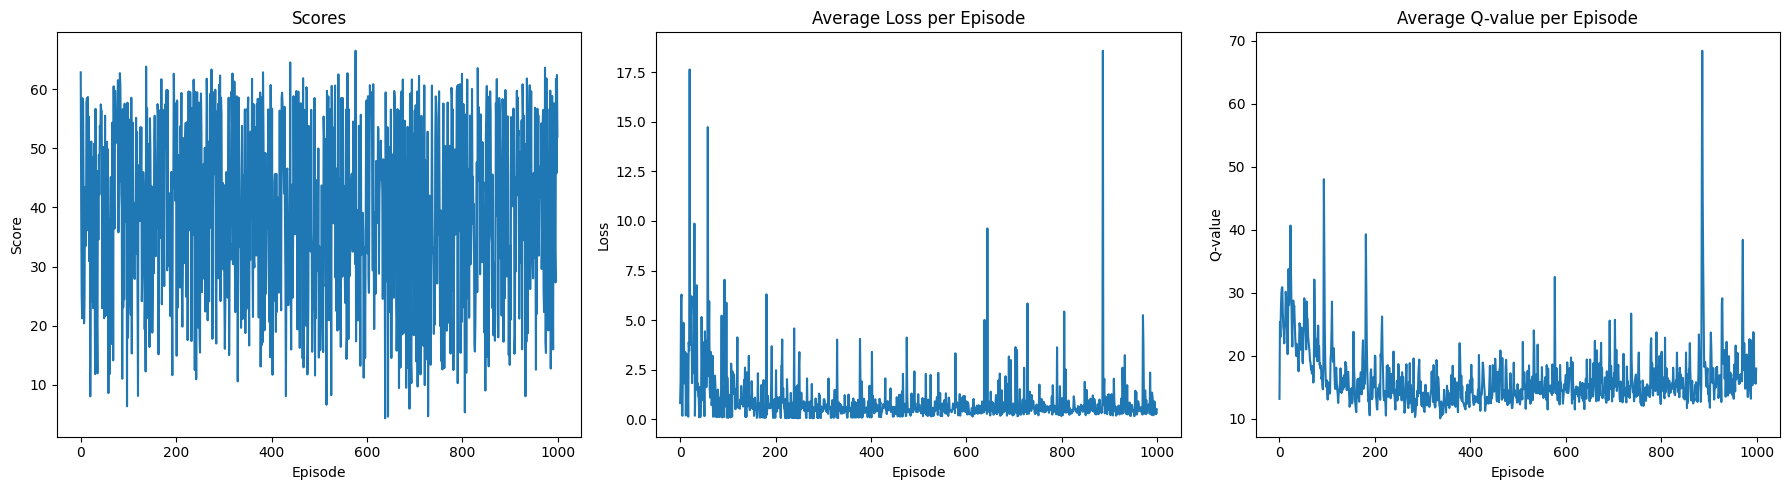

--- Evaluation Summary ---
Average Score: 39.18
Average Q-value: 16.3885
Training Time: 583.43 seconds
Score / Time: 0.0671
Q-value / Time: 0.0281


In [59]:
## TASK 1
model = SnakeDQN(state_shape, n_actions=3).to(device)

start = time.time()
trained_model, scores, losses, q_values = train_dqn_simple(game_instance, model, using_heuristic=True, heuristic=heuristic)
end = time.time()

# Plot
plot_training_metrics(scores, losses, q_values)

# Evaluate
evaluate_efficiency(scores, q_values, total_time=end - start)

In [ ]:
## TASK 2 ONWARDS
policy_net = SnakeDQN(state_shape, n_actions=3)
target_net = SnakeDQN(state_shape, n_actions=3)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

replay_buffer = PrioritizedReplayBuffer(capacity=REPLAY_BUFFER_SIZE, alpha=0.6)

#train_dqn2(game_instance, policy_net, target_net, max_train_episodes=100)
start = time.time()
scores, losses, q_values = train_dqn3(game_instance, policy_net, target_net, exploration_style="epsilon", decay_pattern="fixed", max_train_episodes=1000, replay_buffer=replay_buffer)
end = time.time()

# Plot
plot_training_metrics(scores, losses, q_values)

# Evaluate
evaluate_efficiency(scores, q_values, total_time=end - start)


[Warm Start] Filling buffer with 50 heuristic games...
[Heuristic Baseline] Average score over 50 games: 39.88
Episode 10 | Score: 0.65 | Loss: 0.2325 | Q-value: 0.4175 | Eps: 0.050
Episode 20 | Score: 0.45 | Loss: 0.3680 | Q-value: 0.5504 | Eps: 0.050
Episode 30 | Score: 0.65 | Loss: 0.3611 | Q-value: 0.4406 | Eps: 0.050
Episode 40 | Score: 0.60 | Loss: 0.2419 | Q-value: 0.5001 | Eps: 0.050
Episode 50 | Score: 0.35 | Loss: 0.1973 | Q-value: 0.5951 | Eps: 0.050
Episode 50, Avg Score: 0.51
Episode 60 | Score: 2.36 | Loss: 0.1636 | Q-value: 0.4662 | Eps: 0.050
Episode 70 | Score: 1.30 | Loss: 0.1663 | Q-value: 0.3659 | Eps: 0.050
Episode 80 | Score: 1.00 | Loss: 0.0719 | Q-value: 0.0004 | Eps: 0.050
Episode 90 | Score: 1.03 | Loss: 0.0643 | Q-value: 0.0048 | Eps: 0.050
Episode 100 | Score: 1.00 | Loss: 0.0708 | Q-value: 0.0802 | Eps: 0.050
Episode 100, Avg Score: 0.82
Episode 110 | Score: 3.85 | Loss: 0.0533 | Q-value: 0.0926 | Eps: 0.050
Episode 120 | Score: 1.01 | Loss: 0.0779 | Q-val

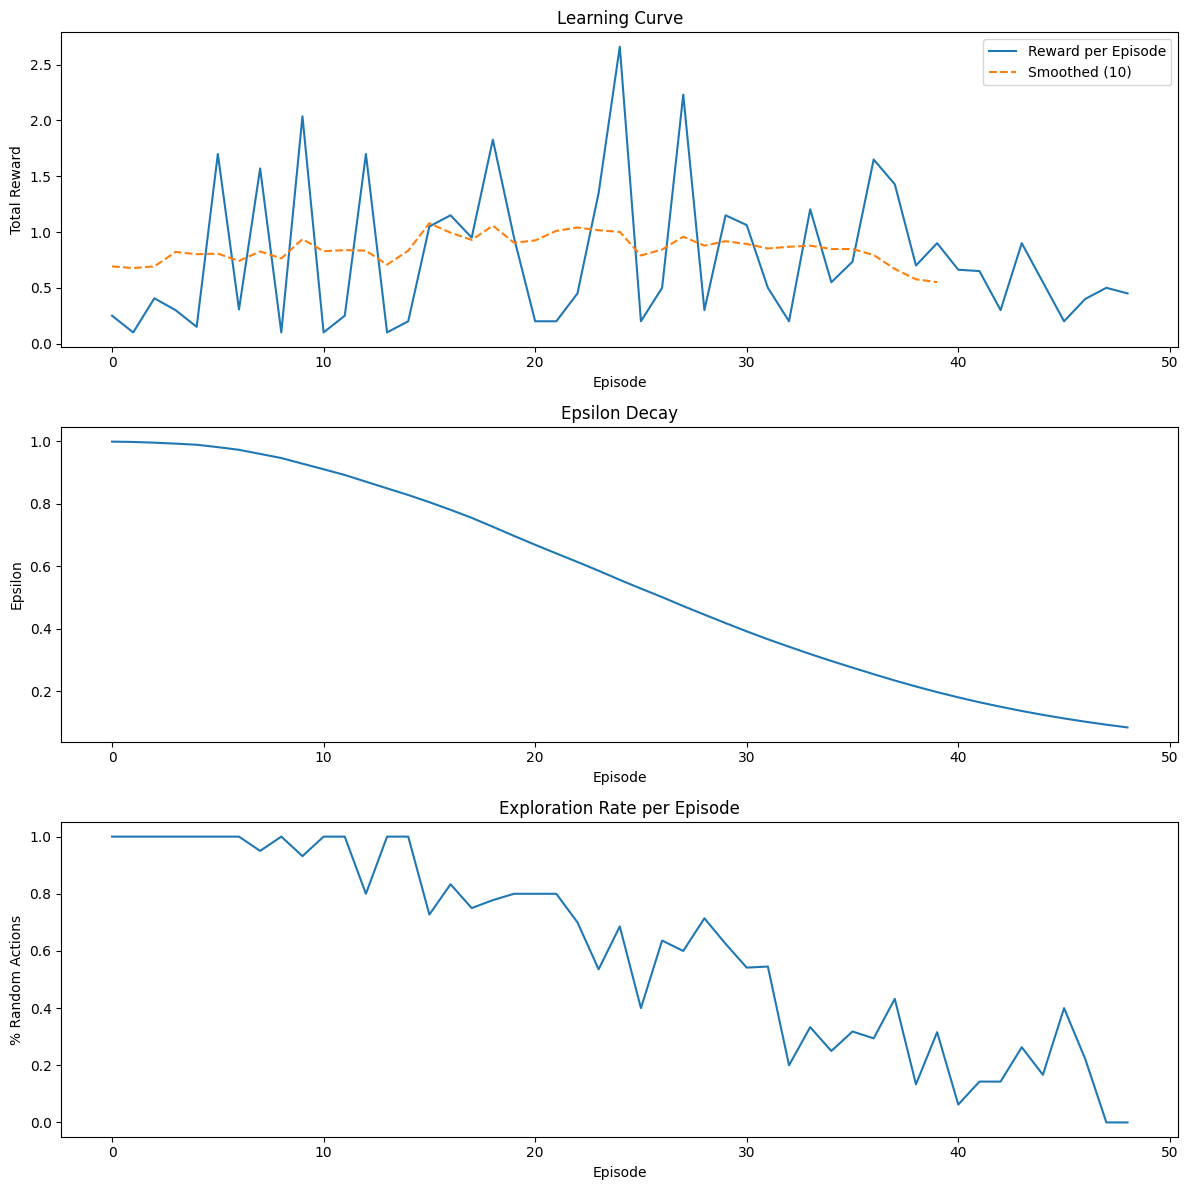

In [89]:
def plot_training_metrics():
    fig, axs = plt.subplots(3, 1, figsize=(12, 12))

    axs[0].plot(episode_rewards, label='Reward per Episode')
    axs[0].plot(np.convolve(episode_rewards, np.ones(10)/10, mode='valid'), label='Smoothed (10)', linestyle='--')
    axs[0].set_title('Learning Curve')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].legend()

    if epsilon_history:
        axs[1].plot(epsilon_history)
        axs[1].set_title('Epsilon Decay')
        axs[1].set_ylabel('Epsilon')
        axs[1].set_xlabel('Episode')
    elif temperature_history:
        axs[1].plot(temperature_history)
        axs[1].set_title('Temperature Decay')
        axs[1].set_ylabel('Temperature')
        axs[1].set_xlabel('Episode')

    axs[2].plot(exploration_count)
    axs[2].set_title('Exploration Rate per Episode')
    axs[2].set_ylabel('% Random Actions')
    axs[2].set_xlabel('Episode')

    plt.tight_layout()
    plt.show()

plot_training_metrics()

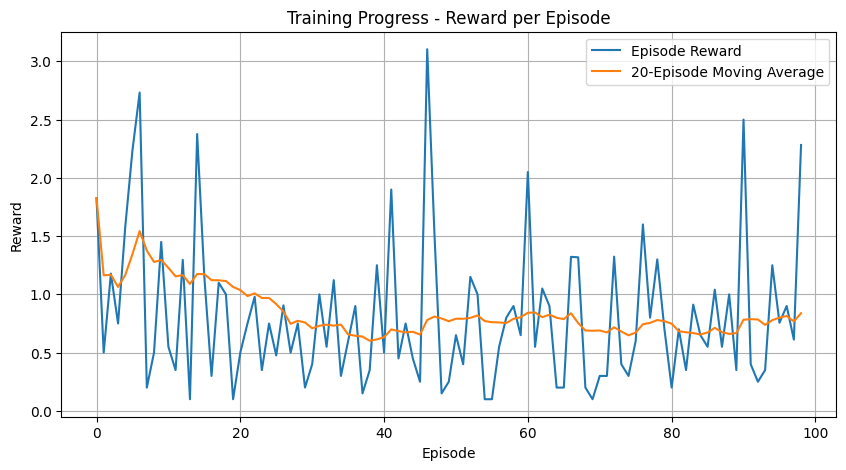

In [61]:
def plot_training_progress(scores):
    plt.figure(figsize=(10,5))
    plt.plot(scores, label='Episode Reward')
    
    window = 20
    if len(scores) >= window:
        moving_avg = [np.mean(scores[max(0, i-window):i+1]) for i in range(len(scores))]
        plt.plot(moving_avg, label=f'{window}-Episode Moving Average')
    
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Progress - Reward per Episode')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_training_progress(scores)
#history['info']

In [6]:
def plot_board(board,text=None):
    plt.figure(figsize=(2,2))
    plt.imshow(board)
    plt.axis('off')
    if text is not None:
        plt.gca().text(3, 3, text, fontsize=45,color = 'yellow')
    #plt.savefig(file_name,bbox_inches='tight')
    plt.show()
    plt.close()